# Permutational variable importance for explaining models on the Titanic dataset

author: Witalis Domitrz <witekdomitrz@gmail.com>

model: XGBClassifier 	accuracy: 0.8827751196172249


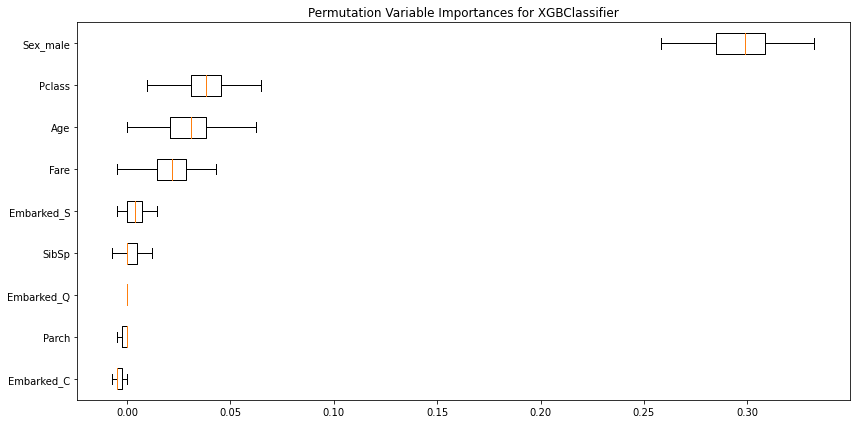

In [15]:
show_acc_and_plot_permutation_importance(model1_name, model1, n_repeats=100)

For the first model the most important variable is, as we saw before on instances level, the sex of the observation. It dominates all other parameters and has, proportionally to the value, quite small variance. The value of ~0.3 is clear indication that that variable is indeed important. There are also three other variables that have a noticeable impact on the prediction - class, age and fare. It is important to recall that when inspecting the model with LIME for most instances those were also the most impactful parameters (except the sex). There is also one interesting thing - the number of siblings, while generally impacts prediction in correct way, sometimes after the permutation improves the model's accuracy, which might be a motivation for a deeper inspection of the model.

model: RandomForestClassifier 	accuracy: 0.8181818181818182


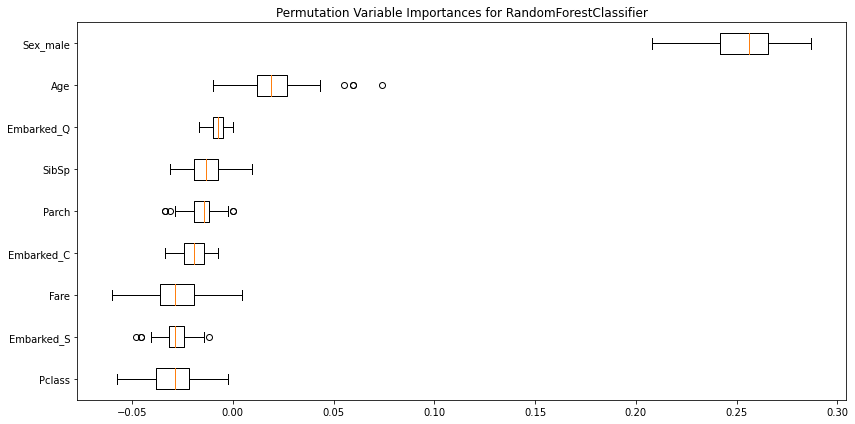

model: DecisionTreeClassifier 	accuracy: 0.7942583732057417


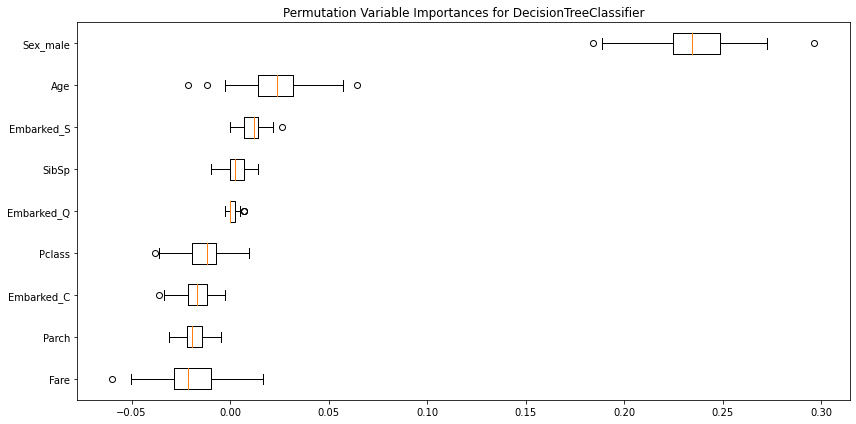

model: SGDClassifier 	accuracy: 0.5215311004784688


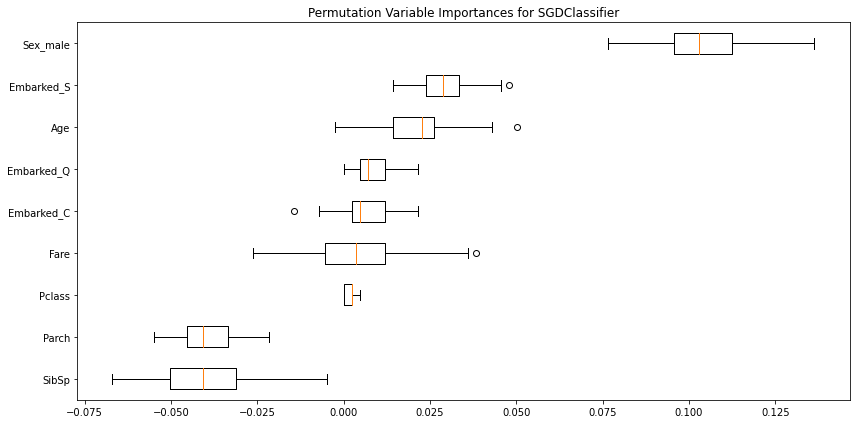

model: KNeighborsClassifier 	accuracy: 0.6722488038277512


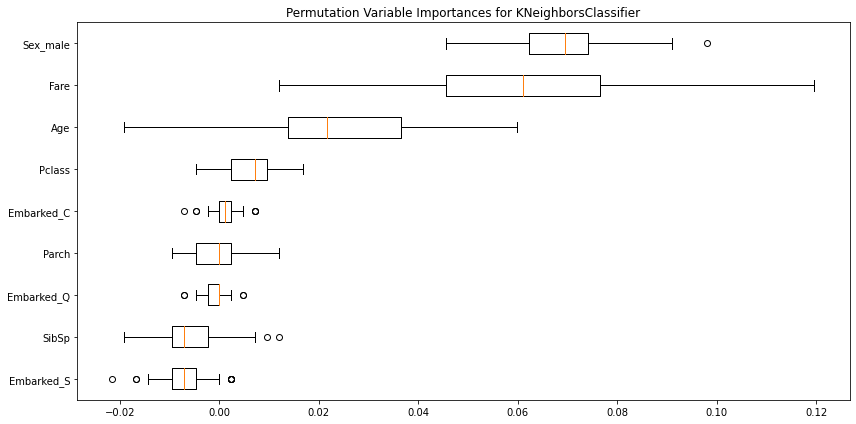

In [16]:
for model_name, model in models.items():
    show_acc_and_plot_permutation_importance(model_name, model, n_repeats=100)

We can clearly see that while all the models doubtless precise the sex as very important, its importance is varying strongly across the models. While there is similar situation with the fare, some models rely on the city of embarkation, the others does not perceive it as an important feature. Combaining that knowledge with the fact that the weakest model relies on this features the most we may conclude that there is some not very accurate correlation between the probability of the survival and the city of embarkation. Last, but not least fact is that the information about the fare is not correctly utilised by the additional models, as it is by the main model and this might be the reason of lower performance.

# Appendix

## Preparation

### Install modules

### Download the data

In [1]:
!wget http://students.mimuw.edu.pl/~wd393711/iml/titanic.zip
!unzip -o titanic.zip
!rm titanic.zip

--2020-05-04 14:13:41--  http://students.mimuw.edu.pl/~wd393711/iml/titanic.zip
Resolving students.mimuw.edu.pl (students.mimuw.edu.pl)... 193.0.96.129, 2001:6a0:5001:1::3
Connecting to students.mimuw.edu.pl (students.mimuw.edu.pl)|193.0.96.129|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34877 (34K) [application/zip]
Saving to: ‘titanic.zip’

titanic.zip         100%[===================>]  34,06K  --.-KB/s    in 0,007s  

2020-05-04 14:13:41 (4,99 MB/s) - ‘titanic.zip’ saved [34877/34877]

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


### Prepare the data

In [2]:
import numpy as np
import pandas as pd

used_columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived']
X_columns = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
Y_columns = ['Survived']

def load_data(fn):
    return pd.read_csv(fn).set_index('PassengerId')

def to_array(data):
    return pd.get_dummies(data).astype(dtype='float32')

def data_preprocessing():
    global train, test
    train = load_data('./train.csv')
    test = load_data('./gender_submission.csv').join(load_data('./test.csv'))  

    train['is_train'] = True
    test['is_train'] = False
    data = pd.concat([train, test])

    # Replace missing values with mean
    data.fillna(data.mean(), inplace=True)

    # Split test and train
    train, test = data[data['is_train']], data[data['is_train'] == False]

    # No unused columns
    train, test = train[used_columns], test[used_columns]

    train, test = to_array(train), to_array(test)
data_preprocessing()


def split_to_x_y(data):
    return to_array(data[X_columns]), to_array(data[Y_columns])

def get_data():
    return split_to_x_y(train), split_to_x_y(test)

def unlabel_data(*sets):
    return ((part.values for part in subset) for subset in sets)

In [3]:
(train_x, train_y), (test_x, test_y) = get_data()

## 1.
For the selected data set, train at least one tree-based ensemble model (random forest, gbm, catboost or any other boosting)

In [4]:
from xgboost import XGBClassifier

### Create a model

In [5]:
model1 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                       colsample_bynode=1, colsample_bytree=1, gamma=0,
                       learning_rate=0.1, max_delta_step=0, max_depth=4,
                       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
                       nthread=None, objective='binary:logistic', random_state=0,
                       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                       silent=None, subsample=1, verbosity=1)
model1_name = "XGBClassifier"

### Train a model

In [6]:
model1.fit(train_x, train_y.values[::,0])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=1, nthread=1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
              subsample=1, tree_method=None, validate_parameters=False,
              verbosity=1)

### Function to check a model accuracy

In [7]:
from sklearn.metrics import accuracy_score
def check_accuracy(model, xy=(test_x, test_y)):
    x, y = xy
    pred = model.predict(x)
    accuracy = accuracy_score(y, [round(value) for value in pred])
    return accuracy

## 2.
calculate permutational variable importance for the selected model,

### Use permutation_importance from scikit-learn

In [8]:
from sklearn.inspection import permutation_importance

### Plot as here: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html

In [9]:
import matplotlib.pyplot as plt
def show_acc_and_plot_permutation_importance(model_name, model, xy=(test_x, test_y), **kwargs):
    
    print("model:", model_name, "\taccuracy:", check_accuracy(model, xy=xy))
    
    x, y = xy

    result = permutation_importance(model, x, y, **kwargs)
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots(figsize=(12,6))
    ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=x.columns[sorted_idx])
    ax.set_title("Permutation Variable Importances for " + model_name)
    fig.tight_layout()
    plt.show()

model: XGBClassifier 	accuracy: 0.8827751196172249


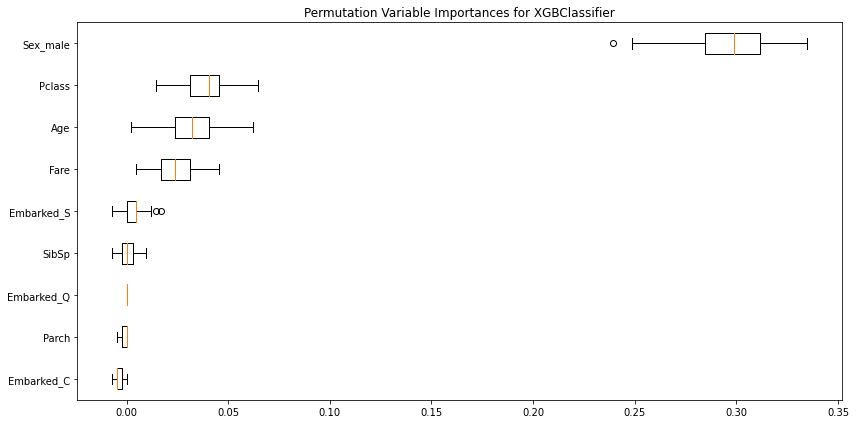

In [10]:
show_acc_and_plot_permutation_importance(model1_name, model1, n_repeats=100)

## 3.
train three or more candidate models (different variables, different transformations, different model structures) and compare ranking of important features between these models. Are they similar or different?

### Use scikit-learn random forest classifier, decision tree classifier, linear classifier and k-nearest neighbours classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

### Create the models

In [12]:
models = {
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0), 
    "SGDClassifier": SGDClassifier(random_state=0),
    "KNeighborsClassifier": KNeighborsClassifier()}

### Fit the models

In [13]:
for model_name, model in models.items():
    print("Training", model_name)
    model.fit(train_x, train_y.values[::,0])

Training RandomForestClassifier
Training DecisionTreeClassifier
Training SGDClassifier
Training KNeighborsClassifier


### Plot permutational variable importance along with accuracy for those models

model: RandomForestClassifier 	accuracy: 0.8181818181818182


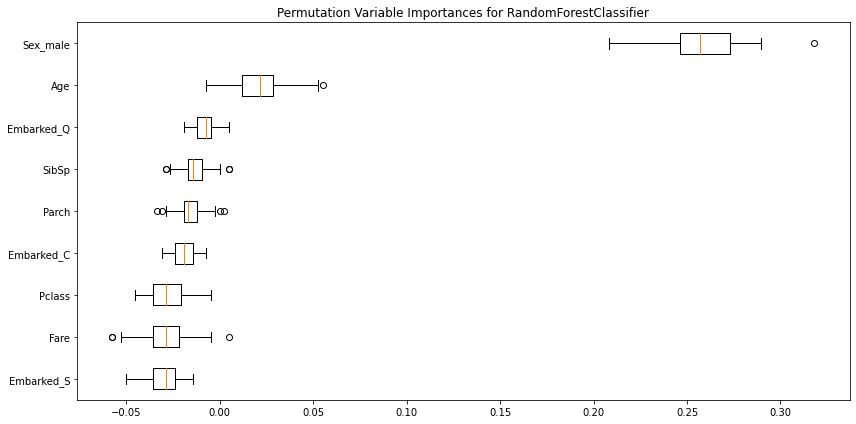

model: DecisionTreeClassifier 	accuracy: 0.7942583732057417


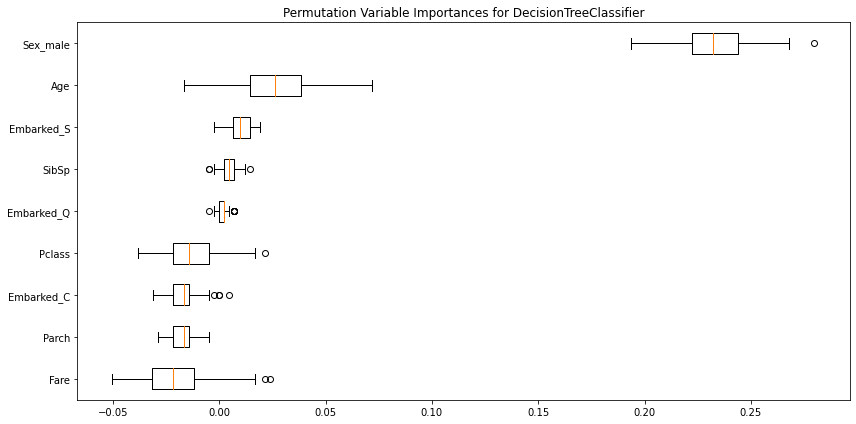

model: SGDClassifier 	accuracy: 0.5215311004784688


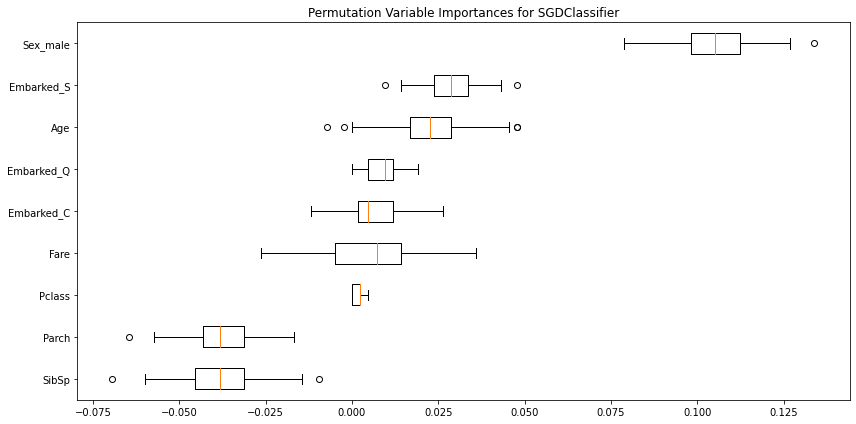

model: KNeighborsClassifier 	accuracy: 0.6722488038277512


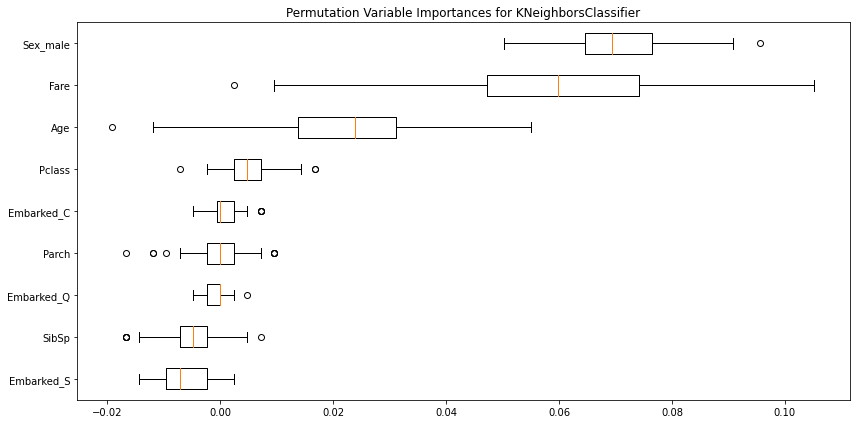

In [14]:
for model_name, model in models.items():
    show_acc_and_plot_permutation_importance(model_name, model, n_repeats=100)

## 4.
Comment on the results for points (2) and (3)

2. permutational variable importance for the first model

    For the first model the most important variable is, as we saw before on instances level, the sex of the observation. It dominates all other parameters and has, proportionally to the value, quite small variance. The value of ~0.3 is clear indication that that variable is indeed important. There are also three other variables that have a noticeable impact on the prediction - class, age and fare. It is important to recall that when inspecting the model with LIME for most instances those were also the most impactful parameters (except the sex). There is also one interesting thing - the number of siblings, while generally impacts prediction in correct way, sometimes after the permutation improves the model's accuracy, which might be a motivation for a deeper inspection of the model.

3. permutational variable importance for the other models
    
     We can clearly see that while all the models doubtless precise the sex as very important, its importance is varying strongly across the models. While there is similar situation with the fare, some models rely on the city of embarkation, the others does not perceive it as an important feature. Combaining that knowledge with the fact that the weakest model relies on this features the most we may conclude that there is some not very accurate correlation between the probability of the survival and the city of embarkation. Last, but not least fact is that the information about the fare is not correctly utilised by the additional models, as it is by the main model and this might be the reason of lower performance.